In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
df = gpd.read_parquet(
    "s3://weave.energy/smart-meter", 
    filters=[("data_collection_log_timestamp", "==", pd.Timestamp("2024-07-14T20:00:00Z"))])

print("Number of rows: ", len(df))
df.head()


Number of rows:  89358


,dataset_id,dno_alias,aggregated_device_count_active,total_consumption_active_import,data_collection_log_timestamp,geometry,secondary_substation_unique_id,lv_feeder_unique_id
0,NGED_110191_11_Jul_2024,NGED,26.0,7693.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-11
1,NGED_110191_21_Jul_2024,NGED,28.0,4135.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-21
2,NGED_110191_22_Jul_2024,NGED,11.0,1920.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-22
3,NGED_110191_31_Jul_2024,NGED,23.0,4547.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-31
4,NGED_110191_42_Jul_2024,NGED,24.0,3412.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-42


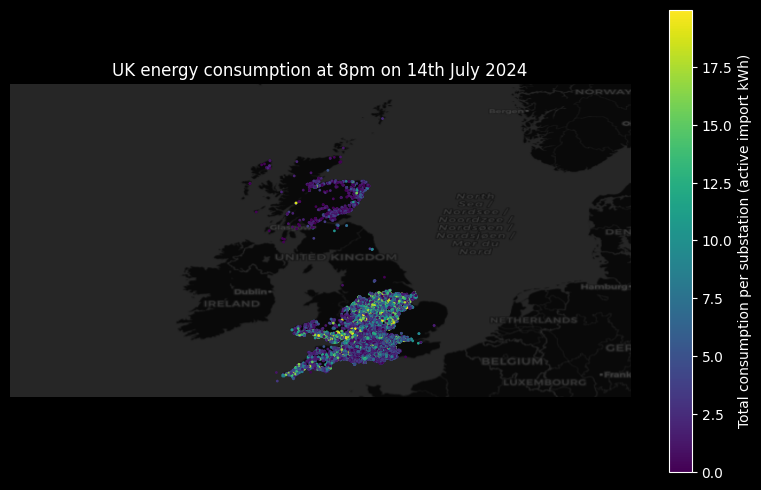

In [4]:
substations = df.groupby(["secondary_substation_unique_id", "geometry"], as_index=False).sum("total_consumption_active_import").set_geometry("geometry")
# There are still issues with extreme outliers, so we filter them out
substations = substations[substations["total_consumption_active_import"] < 20000]

# Turn Wh consumption into kWh
substations["total_consumption_active_import"] /= 1000


ax = substations.plot(kind="geo", column="total_consumption_active_import", markersize=1, legend=True, legend_kwds={"label": "Total consumption per substation (active import kWh)"}, figsize=(10, 6))
ax.set_title("UK energy consumption at 8pm on 14th July 2024")
ax.set_axis_off()
ax.set_xlim(-18, 10)
ax.set_ylim(49.25, 61.5)
cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.DarkMatter, attribution=False)
plt.savefig("../etc/figures/uk_consumption_8pm_july_14_2024.png")
plt.show()

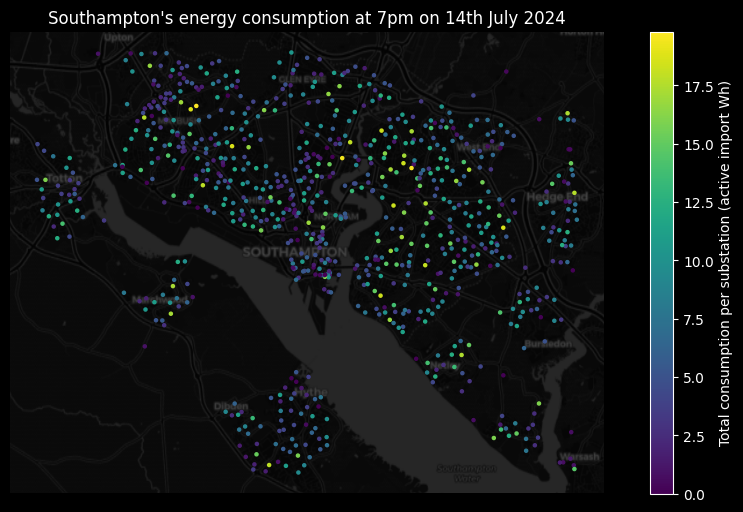

In [3]:
bbox = (-1.5,50.85,-1.3,50.95)
gdf = gpd.read_parquet("s3://weave.energy/smart-meter", bbox=bbox, filters=[("data_collection_log_timestamp", "=", pd.Timestamp("2024-07-14 20:00Z"))])
substations = gdf.groupby(["secondary_substation_unique_id", "geometry"], as_index=False).sum("total_consumption_active_import").set_geometry("geometry", crs=4326)
substations = substations[substations["total_consumption_active_import"] < 20000]
# Turn Wh consumption into kWh
substations["total_consumption_active_import"] /= 1000
ax = substations.plot(kind="geo", column="total_consumption_active_import", markersize=5, legend=True, legend_kwds={"label": "Total consumption per substation (active import Wh)"}, figsize=(12, 6))
ax.set_title("Southampton's energy consumption at 7pm on 14th July 2024")
ax.set_axis_off()
ax.set_facecolor("#1B2526")
cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.DarkMatter, attribution=False)
plt.savefig("../etc/figures/southampton_consumption_7pm_july_14_2024.png")
plt.show()

In [5]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

### Reading from Local Downloaded Parquet File

### Load in Only Data from December in London

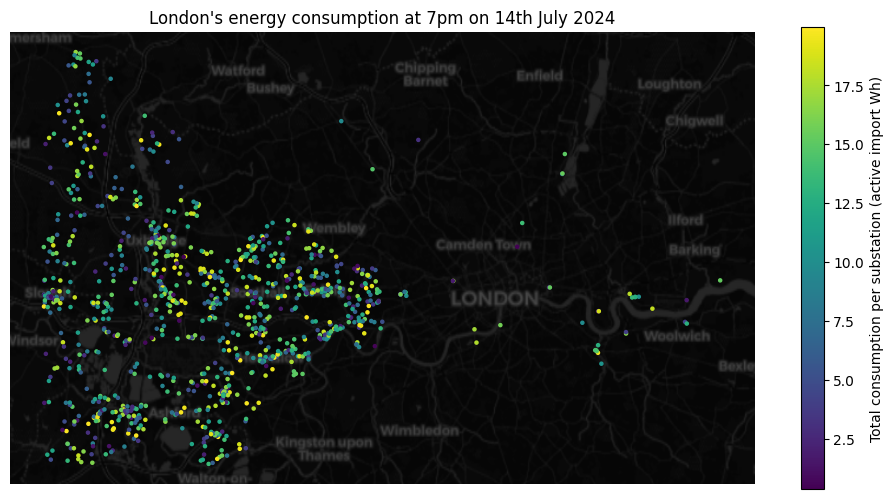

In [10]:
london_bbox = (-0.6, 51.4, 0.4, 51.7)
london_df_for_visualization = london_df = gpd.read_parquet("/Users/vaibhavsourirajan/Documents/COLUMBIA/Senior/WattCast/2024-12.parquet", 
                                                          bbox=london_bbox,
                                                          filters=[("data_collection_log_timestamp", "=", pd.Timestamp("2024-12-14 20:00Z"))])

substations = london_df_for_visualization.groupby(["secondary_substation_unique_id", "geometry"], as_index=False).sum("total_consumption_active_import").set_geometry("geometry", crs=4326)
substations = substations[substations["total_consumption_active_import"] < 20000]
# Turn Wh consumption into kWh
substations["total_consumption_active_import"] /= 1000
ax = substations.plot(kind="geo", column="total_consumption_active_import", markersize=5, legend=True, legend_kwds={"label": "Total consumption per substation (active import Wh)"}, figsize=(12, 6))
ax.set_title("London's energy consumption at 8pm on 14th July 2024")
ax.set_axis_off()
ax.set_facecolor("#1B2526")
cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.DarkMatter, attribution=False)


In [7]:
gdf = gpd.read_parquet("/Users/vaibhavsourirajan/Documents/COLUMBIA/Senior/WattCast/2024-12.parquet", 
                       filters=[("dno_alias", "==", "SSEN"), ("secondary_substation_unique_id", "==", 
                                                              "SSEN-6400603160")])

gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4413 entries, 0 to 4412
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   dataset_id                       4413 non-null   object             
 1   dno_alias                        4413 non-null   object             
 2   aggregated_device_count_active   4413 non-null   int64              
 3   total_consumption_active_import  4413 non-null   int64              
 4   data_collection_log_timestamp    4413 non-null   datetime64[ms, UTC]
 5   geometry                         4413 non-null   geometry           
 6   secondary_substation_unique_id   4413 non-null   object             
 7   lv_feeder_unique_id              4413 non-null   object             
dtypes: datetime64[ms, UTC](1), geometry(1), int64(2), object(4)
memory usage: 275.9+ KB


<Axes: title={'center': 'Daily kWh consumption per low-voltage feeder for a substation in Southampton'}, xlabel='Date', ylabel='Consumption (kWh)'>

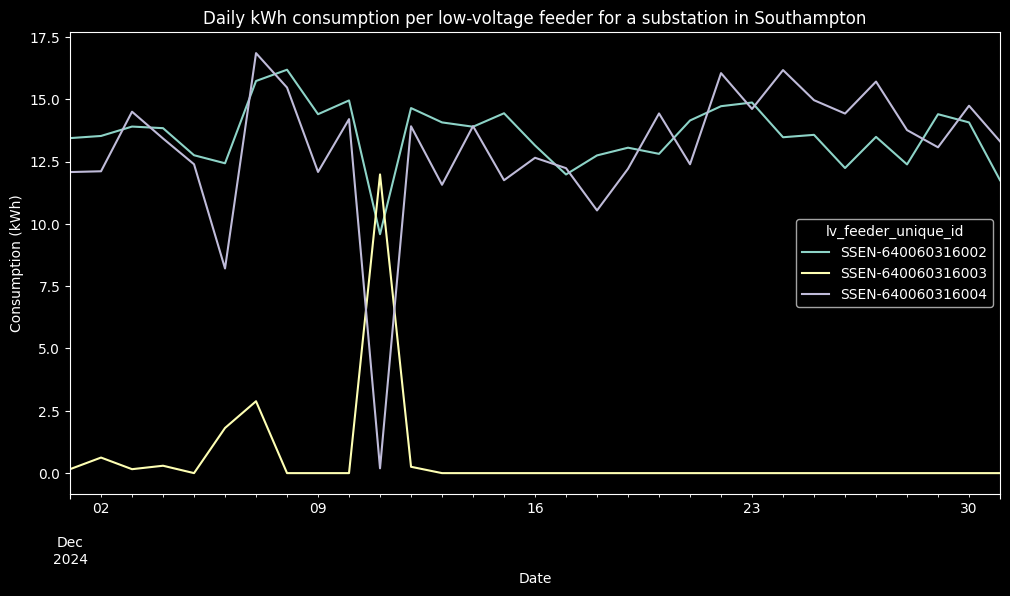

In [10]:
gdf.groupby("lv_feeder_unique_id").agg({
    "lv_feeder_unique_id": ["count"],
    "data_collection_log_timestamp": ["min", "max"],
    "aggregated_device_count_active": ["min", "max"],
    "total_consumption_active_import": ["min", "max"]
})

deduped_gdf = gdf.drop_duplicates(subset=["data_collection_log_timestamp", "lv_feeder_unique_id"]).copy()
deduped_gdf = deduped_gdf[deduped_gdf["total_consumption_active_import"] < 20000]
deduped_gdf["total_consumption_active_import"] /= 1000
deduped_gdf["normalised_consumption"] = deduped_gdf["total_consumption_active_import"] / deduped_gdf["aggregated_device_count_active"]
timeseries = deduped_gdf.pivot(index="data_collection_log_timestamp", columns="lv_feeder_unique_id", values="normalised_consumption")
timeseries.resample("d").sum().plot(figsize=(12,6), xlabel="Date", ylabel="Consumption (kWh)", title="Daily kWh consumption per low-voltage feeder for a substation in Southampton")
